In [1]:
import json
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as mplplot
import matplotlib.patches as patches
import dateutil.parser
import pickle
import sys
import regex
import copy
import itertools
import gc
from collections import Counter

In [2]:
verbose = True
if verbose :
    import pprint
    from IPython.core.display import display
    pprinter = pprint.PrettyPrinter(indent=4)

In [3]:
%matplotlib inline

In [4]:
sampleDataFileName = 'decoding-the-civil-war-classifications.csv'
subjectDataFileName = 'decoding-the-civil-war-subjects.csv'
liveDate = dateutil.parser.parse("2016-06-20T00:00:00.00Z")

## Class that matches and combines boxes

In [5]:
class BoxMatcher() :
    
    def __init__(self, _overlapThreshold = 0.7) :
        self.overlapThreshold = _overlapThreshold
        self.box = None  
        
    def compare(self, otherBox) :
        if self.box is None :
            self.setBox(otherBox)
            return True
        # define "identity" as a degree of area overlap
        selfArea = self.box.width * self.box.height
        otherArea = otherBox.width * otherBox.height
        dx = min(self.box.x + self.box.width, otherBox.x + otherBox.width) - max(self.box.x, otherBox.x) 
        dy = min(self.box.y + self.box.height, otherBox.y + otherBox.height) - max(self.box.y, otherBox.y)
        if dx < 0 or dy < 0 :
            return False
        areaOfOverlap = dx*dy
        unionOfAreas = selfArea + otherArea - areaOfOverlap
        overlapFraction = areaOfOverlap/unionOfAreas
        return overlapFraction > self.overlapThreshold
    
    def setBox(self, newBox) :
        self.box = newBox
          
    @staticmethod
    def mean(boxes):
            
        meanCoMX = meanCoMY = meanWidth = meanHeight = 0.0
        for box in boxes :
            boxCoM = (box.x + 0.5*box.width, box.y + 0.5*box.height)
            meanCoMX += boxCoM[0]
            meanCoMY += boxCoM[1]
            meanWidth += box.width
            meanHeight += box.height
        
        meanBox = TelegramBox(meanCoMX/float(len(boxes)) - 0.5*meanWidth/float(len(boxes)),
                             meanCoMY/float(len(boxes)) - 0.5*meanHeight/float(len(boxes)),
                             meanWidth/float(len(boxes)),
                             meanHeight/float(len(boxes)),
                             {'nBoxes' : len(boxes)})
        return meanBox

## Class encapsulating data about boxes

In [6]:
class TelegramBox() :
    
    def __init__(self, x, y, width, height, data) :
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.data = data
        
    def __str__(self) :
        return 'TelegramBox(x={}, y={}, width={}, height={}, subject={})'.format(self.x, self.y, self.width, self.height, self.data)
    
    def __repr__(self) :
        return self.__str__()

## Parse the downloaded subject data into data structures for processing

In [7]:
subject_data = []
subjectColumns = ['subject_id', 'huntington_id', 'url']
with open(subjectDataFileName) as csvfile :
    parsedSubjectCsv = csv.DictReader(csvfile)
    numPrinted = 0
    for subject in parsedSubjectCsv :
        parsedLocations = json.loads(subject['locations'])
        parsedMetaData = json.loads(subject['metadata'])
        if 'hdl_id' not in parsedMetaData :
            continue
        subject_data.append({'subject_id': int(subject['subject_id']), 
                             'huntington_id' : parsedMetaData['hdl_id'],
                             'collection' : parsedMetaData['hdl_id'][3:5],
                             'ledger' : int(parsedMetaData['hdl_id'][6:8]),
                             'page' : int(parsedMetaData['hdl_id'][9:12]),
                             'variant' : parsedMetaData['hdl_id'][12:],
                             'telegramNumbers' : [int(regex.findall(r'[0-9]+', telegramNumber)[0]) for telegramNumber in regex.findall(r"[\w']+", parsedMetaData['#telegrams']) if len(telegramNumber) > 3], 
                             'url' : parsedLocations['0']})
subjectsFrame = pd.DataFrame.from_records(subject_data, index = 'subject_id')
display(subjectsFrame)

,collection,huntington_id,ledger,page,telegramNumbers,url,variant
subject_id,,,,,,,
1959268,EC,mssEC_01_001,1,1,[],https://panoptes-uploads.zooniverse.org/produc...,
1959269,EC,mssEC_01_002,1,2,[],https://panoptes-uploads.zooniverse.org/produc...,
1959270,EC,mssEC_01_003,1,3,[],https://panoptes-uploads.zooniverse.org/produc...,
1959271,EC,mssEC_01_004,1,4,[],https://panoptes-uploads.zooniverse.org/produc...,
1959272,EC,mssEC_01_005,1,5,[],https://panoptes-uploads.zooniverse.org/produc...,
1959273,EC,mssEC_01_006,1,6,[],https://panoptes-uploads.zooniverse.org/produc...,
1959274,EC,mssEC_01_007,1,7,"[1, 2, 3]",https://panoptes-uploads.zooniverse.org/produc...,
1959275,EC,mssEC_01_008,1,8,[4],https://panoptes-uploads.zooniverse.org/produc...,
1959276,EC,mssEC_01_009,1,9,[5],https://panoptes-uploads.zooniverse.org/produc...,


## Parse the downloaded box data into data structures for processing

In [8]:
allBoxes = {}

onePrinted = False

with open(sampleDataFileName) as csvfile :
    parsedCsv = csv.DictReader(csvfile)
    nSubjectsParsed = 0
    for recordIndex, record in enumerate(parsedCsv) :
        
        subjectBoxes = []
        
        # check the date that the classification was made
        parsedMetadata = json.loads(record["metadata"])
        parsedDate = dateutil.parser.parse(parsedMetadata['started_at'])

        # skip "testing" data before the site went live
        if parsedDate < liveDate :
            continue
        
        # parse the annotations and the subject data
        parsedAnnotations = json.loads(record["annotations"])
        parsedSubjectData = json.loads(record["subject_data"])
        
        #loop over tasks in the annotation
        for task in parsedAnnotations :
            # Check for recorded box data
            if task['task'] == "T2" and task['value'] :
                for box in task['value'] :
                    subjectBoxes.append(TelegramBox(box['x'], box['y'], box['width'], box['height'], int(record['subject_ids'])))
                
        nSubjectsParsed += 1
        if int(record['subject_ids']) in allBoxes :
            allBoxes[int(record['subject_ids'])].append((recordIndex, subjectBoxes))
        else :
            allBoxes.update({int(record['subject_ids']) : [(recordIndex, subjectBoxes)]}) 

In [9]:
allBoxData = []
for key, boxes in allBoxes.items() :
    for boxData in boxes :
        for boxDatum in boxData[1] :
            allBoxData.append({'subjectKey' : key, 
                               'box' : boxDatum, 
                               'boxX' : boxDatum.x, 
                               'boxY' : boxDatum.y, 
                               'boxW' : boxDatum.width, 
                               'boxH' : boxDatum.height })
            
allBoxesFrame = pd.DataFrame(data = allBoxData)

allBoxesFrameIndex = pd.MultiIndex.from_arrays([allBoxesFrame['subjectKey'], 
                                                allBoxesFrame['boxY'], 
                                                allBoxesFrame['boxH'], 
                                                allBoxesFrame['boxX'], 
                                                allBoxesFrame['boxW'],])

allBoxesFrame.set_index(allBoxesFrameIndex, inplace=True, drop=False)
allBoxesFrame.sort_index(inplace=True)
display(allBoxesFrame)

box  \
subjectKey boxY        boxH        boxX       boxW                                                             
1959274    68.503887   611.890651  171.744474 1115.800629  TelegramBox(x=171.7444735531441, y=68.50388691...   
           101.344470  601.443001  194.219971 1099.554401  TelegramBox(x=194.2199710110772, y=101.3444703...   
           146.933063  550.103052  172.067023 1107.373616  TelegramBox(x=172.06702314917362, y=146.933062...   
           147.540027  533.952726  177.524979 1112.430551  TelegramBox(x=177.52497867972883, y=147.540027...   
           153.027876  1826.461745 177.893765 1115.622560  TelegramBox(x=177.89376522533496, y=153.027875...   
           154.997425  533.880020  167.724684 1118.101102  TelegramBox(x=167.72468423107821, y=154.997425...   
           155.097857  532.534477  176.458205 1109.727579  TelegramBox(x=176.45820511721567, y=155.097856...   
           178.621777  511.772161  180.019982 1106.624202  TelegramBox(x=180.01998247939127, y=178.621776...   
           686.199952  617.696065  175.227722 1118.122795  TelegramBox(x=175.2277221359956, y=686.1999520...   
           713.162914  605.650917  168.483290 1109.165483  TelegramBox(x=168.48328976400524, y=713.162914...   
           713.546862  594.045580  182.245096 1100.458784  TelegramBox(x=182.2450961247614, y=713.5468624...   
           717.359878  585.545829  167.724684 1133.998274  TelegramBox(x=167.7246842310781, y=717.3598783...   
           719.347025  614.690644  169.049449 1119.425866  TelegramBox(x=169.04944857007817, y=719.347024...   
           720.302701  601.498449  175.035189 1104.962604  TelegramBox(x=175.03518877756127, y=720.302700...   
           721.200388  596.292301  184.299830 1097.525878  TelegramBox(x=184.29982977966074, y=721.200388...   
           1309.701431 673.428041  175.227722 1122.767127  TelegramBox(x=175.2277221359956, y=1309.701431...   
           1325.426700 351.062544  184.946621 1110.152516  TelegramBox(x=184.94662063807758, y=1325.42670...   
           1329.565031 421.088655  179.234490 1098.414283  TelegramBox(x=179.23448991951037, y=1329.56503...   
           1340.078727 375.521131  180.019982 1109.947398  TelegramBox(x=180.01998247939127, y=1340.07872...   
           1341.972492 364.626407  180.324840 1106.036570  TelegramBox(x=180.3248400555703, y=1341.972491...   
           1341.986254 408.027410  171.698977 1135.323039  TelegramBox(x=171.69897724807808, y=1341.98625...   
           1349.204636 361.841060  192.429651 1077.201325  TelegramBox(x=192.42965109957905, y=1349.20463...   
1959277    73.648143   334.657163  195.726477 1086.452770  TelegramBox(x=195.72647685473137, y=73.6481433...   
           80.327935   331.228768  209.459933 1073.022518  TelegramBox(x=209.45993291962884, y=80.3279346...   
           81.561231   323.224138  227.403963 1042.171289  TelegramBox(x=227.4039625695859, y=81.56123117...   
           83.482419   330.633020  203.209323 1028.732071  TelegramBox(x=203.20932254825328, y=83.4824194...   
           98.337718   297.593937  221.291465 1035.020825  TelegramBox(x=221.29146474578394, y=98.3377181...   
           146.652453  230.932126  211.482746 1049.128285  TelegramBox(x=211.48274615627696, y=146.652452...   
           181.718493  238.609084  218.066042 1015.193190  TelegramBox(x=218.0660417049484, y=181.7184925...   
           421.267380  824.859205  195.726477 1085.274404  TelegramBox(x=195.72647685473137, y=421.267379...   
...                                                                                                      ...   
2880564    59.803443   1032.636785 127.689684 1265.483688  TelegramBox(x=127.68968358984554, y=59.8034426...   
           1114.352945 413.602532  116.733115 1270.961972  TelegramBox(x=116.73311486475039, y=1114.35294...   
2880566    123.865507  577.597444  149.177790 1214.809423  TelegramBox(x=149.1777900839492, y=123.8655068...   
           124.827986  561.466957  137.222776 1242.064294  TelegramBox(x=

## Identify likely matches between classifier box definitions

In [10]:
# Add new column listing the most likely box id
allBoxesFrame['bestBoxIndex'] = pd.Series(np.zeros_like(allBoxesFrame['subjectKey']),
                                          index=allBoxesFrame.index)
subjectKey = None
groupIndex = None
boxMatcher = BoxMatcher(0.7)

for index, data in allBoxesFrame.iterrows() :
    if subjectKey != index[0] :
        subjectKey = index[0]
        groupIndex = 0
    if not boxMatcher.compare(data['box']) :
        groupIndex += 1
    allBoxesFrame.ix[index, 'bestBoxIndex'] = groupIndex  
    boxMatcher.setBox(data['box'])
    
display(allBoxesFrame[['box', 'bestBoxIndex']])

box  \
subjectKey boxY        boxH        boxX       boxW                                                             
1959274    68.503887   611.890651  171.744474 1115.800629  TelegramBox(x=171.7444735531441, y=68.50388691...   
           101.344470  601.443001  194.219971 1099.554401  TelegramBox(x=194.2199710110772, y=101.3444703...   
           146.933063  550.103052  172.067023 1107.373616  TelegramBox(x=172.06702314917362, y=146.933062...   
           147.540027  533.952726  177.524979 1112.430551  TelegramBox(x=177.52497867972883, y=147.540027...   
           153.027876  1826.461745 177.893765 1115.622560  TelegramBox(x=177.89376522533496, y=153.027875...   
           154.997425  533.880020  167.724684 1118.101102  TelegramBox(x=167.72468423107821, y=154.997425...   
           155.097857  532.534477  176.458205 1109.727579  TelegramBox(x=176.45820511721567, y=155.097856...   
           178.621777  511.772161  180.019982 1106.624202  TelegramBox(x=180.01998247939127, y=178.621776...   
           686.199952  617.696065  175.227722 1118.122795  TelegramBox(x=175.2277221359956, y=686.1999520...   
           713.162914  605.650917  168.483290 1109.165483  TelegramBox(x=168.48328976400524, y=713.162914...   
           713.546862  594.045580  182.245096 1100.458784  TelegramBox(x=182.2450961247614, y=713.5468624...   
           717.359878  585.545829  167.724684 1133.998274  TelegramBox(x=167.7246842310781, y=717.3598783...   
           719.347025  614.690644  169.049449 1119.425866  TelegramBox(x=169.04944857007817, y=719.347024...   
           720.302701  601.498449  175.035189 1104.962604  TelegramBox(x=175.03518877756127, y=720.302700...   
           721.200388  596.292301  184.299830 1097.525878  TelegramBox(x=184.29982977966074, y=721.200388...   
           1309.701431 673.428041  175.227722 1122.767127  TelegramBox(x=175.2277221359956, y=1309.701431...   
           1325.426700 351.062544  184.946621 1110.152516  TelegramBox(x=184.94662063807758, y=1325.42670...   
           1329.565031 421.088655  179.234490 1098.414283  TelegramBox(x=179.23448991951037, y=1329.56503...   
           1340.078727 375.521131  180.019982 1109.947398  TelegramBox(x=180.01998247939127, y=1340.07872...   
           1341.972492 364.626407  180.324840 1106.036570  TelegramBox(x=180.3248400555703, y=1341.972491...   
           1341.986254 408.027410  171.698977 1135.323039  TelegramBox(x=171.69897724807808, y=1341.98625...   
           1349.204636 361.841060  192.429651 1077.201325  TelegramBox(x=192.42965109957905, y=1349.20463...   
1959277    73.648143   334.657163  195.726477 1086.452770  TelegramBox(x=195.72647685473137, y=73.6481433...   
           80.327935   331.228768  209.459933 1073.022518  TelegramBox(x=209.45993291962884, y=80.3279346...   
           81.561231   323.224138  227.403963 1042.171289  TelegramBox(x=227.4039625695859, y=81.56123117...   
           83.482419   330.633020  203.209323 1028.732071  TelegramBox(x=203.20932254825328, y=83.4824194...   
           98.337718   297.593937  221.291465 1035.020825  TelegramBox(x=221.29146474578394, y=98.3377181...   
           146.652453  230.932126  211.482746 1049.128285  TelegramBox(x=211.48274615627696, y=146.652452...   
           181.718493  238.609084  218.066042 1015.193190  TelegramBox(x=218.0660417049484, y=181.7184925...   
           421.267380  824.859205  195.726477 1085.274404  TelegramBox(x=195.72647685473137, y=421.267379...   
...                                                                                                      ...   
2880564    59.803443   1032.636785 127.689684 1265.483688  TelegramBox(x=127.68968358984554, y=59.8034426...   
           1114.352945 413.602532  116.733115 1270.961972  TelegramBox(x=116.73311486475039, y=1114.35294...   
2880566    123.865507  577.597444  149.177790 1214.809423  TelegramBox(x=149.1777900839492, y=123.8655068...   
           124.827986  561.466957  137.222776 1242.064294  TelegramBox(x=

In [11]:
allBoxesFrameReindexed = allBoxesFrame.reset_index(level=[1,2,3,4], drop=True)  
allBoxesFrameReindexed.set_index('bestBoxIndex', append=True, inplace=True)
display(allBoxesFrameReindexed)

box  \
subjectKey bestBoxIndex                                                      
1959274    0             TelegramBox(x=171.7444735531441, y=68.50388691...   
           0             TelegramBox(x=194.2199710110772, y=101.3444703...   
           0             TelegramBox(x=172.06702314917362, y=146.933062...   
           0             TelegramBox(x=177.52497867972883, y=147.540027...   
           1             TelegramBox(x=177.89376522533496, y=153.027875...   
           2             TelegramBox(x=167.72468423107821, y=154.997425...   
           2             TelegramBox(x=176.45820511721567, y=155.097856...   
           2             TelegramBox(x=180.01998247939127, y=178.621776...   
           3             TelegramBox(x=175.2277221359956, y=686.1999520...   
           3             TelegramBox(x=168.48328976400524, y=713.162914...   
           3             TelegramBox(x=182.2450961247614, y=713.5468624...   
           3             TelegramBox(x=167.7246842310781, y=717.3598783...   
           3             TelegramBox(x=169.04944857007817, y=719.347024...   
           3             TelegramBox(x=175.03518877756127, y=720.302700...   
           3             TelegramBox(x=184.29982977966074, y=721.200388...   
           4             TelegramBox(x=175.2277221359956, y=1309.701431...   
           5             TelegramBox(x=184.94662063807758, y=1325.42670...   
           5             TelegramBox(x=179.23448991951037, y=1329.56503...   
           5             TelegramBox(x=180.01998247939127, y=1340.07872...   
           5             TelegramBox(x=180.3248400555703, y=1341.972491...   
           5             TelegramBox(x=171.69897724807808, y=1341.98625...   
           5             TelegramBox(x=192.42965109957905, y=1349.20463...   
1959277    1             TelegramBox(x=195.72647685473137, y=73.6481433...   
           1             TelegramBox(x=209.45993291962884, y=80.3279346...   
           1             TelegramBox(x=227.4039625695859, y=81.56123117...   
           1             TelegramBox(x=203.20932254825328, y=83.4824194...   
           1             TelegramBox(x=221.29146474578394, y=98.3377181...   
           1             TelegramBox(x=211.48274615627696, y=146.652452...   
           2             TelegramBox(x=218.0660417049484, y=181.7184925...   
           3             TelegramBox(x=195.72647685473137, y=421.267379...   
...                                                                    ...   
2880564    1             TelegramBox(x=127.68968358984554, y=59.8034426...   
           2             TelegramBox(x=116.73311486475039, y=1114.35294...   
2880566    1             TelegramBox(x=149.1777900839492, y=123.8655068...   
           1             TelegramBox(x=137.22277601181457, y=124.827985...   
           1             TelegramBox(x=157.58858896871982, y=134.452586...   
           1             TelegramBox(x=131.69747249154508, y=137.462151...   
           1             TelegramBox(x=165.9280506904806, y=174.7050044...   
           2             TelegramBox(x=161.98189668128705, y=183.912698...   
           3             TelegramBox(x=144.4741939061315, y=698.7259451...   
           3             TelegramBox(x=145.20349535308088, y=708.086774...   
           4             TelegramBox(x=138.03213441298902, y=713.916334...   
           4             TelegramBox(x=157.58858896871982, y=719.029048...   
           4             TelegramBox(x=157.0838210845349, y=735.7278020...   
           5             TelegramBox(x=143.09986395014423, y=1143.40637...   
           5             TelegramBox(x=156.28953015205585, y=1145.12033...   
           5             TelegramBox(x=148.82804998397518, y=1146.77437...   
2880574    1             TelegramBox(x=123.84619600333947, y=86.6100100...   
           1             TelegramBox(x=155.45034710167522, y=131.998621...   
           1             TelegramBox(x=142.40108480612187, y=157.951961...   
           1   

In [12]:
aggregatedBoxesFrame = allBoxesFrameReindexed.groupby(level=[0,1]).aggregate({'box' : BoxMatcher.mean})
display(aggregatedBoxesFrame)

box
subjectKey bestBoxIndex                                                   
1959274    0             TelegramBox(x=178.88911159828092, y=116.080361...
           1             TelegramBox(x=177.89376522533496, y=153.027875...
           2             TelegramBox(x=174.73429060922842, y=162.905686...
           3             TelegramBox(x=174.58075134044861, y=713.017102...
           4             TelegramBox(x=175.22772213599558, y=1309.70143...
           5             TelegramBox(x=181.44242690670103, y=1338.03897...
1959277    1             TelegramBox(x=211.42898429904335, y=94.0016499...
           2             TelegramBox(x=218.06604170494842, y=181.718492...
           3             TelegramBox(x=206.99602280657928, y=439.786184...
           4             TelegramBox(x=209.83452424802067, y=1282.99732...
           5             TelegramBox(x=202.48616136388296, y=1539.82874...
1959279    1             TelegramBox(x=198.59015637110213, y=105.629247...
           2             TelegramBox(x=200.68969849840653, y=933.620893...
1959281    1             TelegramBox(x=189.5936219325414, y=156.6401582...
1959286    1             TelegramBox(x=183.23409623959128, y=116.523775...
           2             TelegramBox(x=177.19389092683357, y=1885.12000...
1959290    1             TelegramBox(x=1382.4621576278887, y=1.01909866...
           2             TelegramBox(x=154.98480913347305, y=85.1945607...
           3             TelegramBox(x=1423.2261034305507, y=104.967162...
           4             TelegramBox(x=178.28485111305042, y=129.269660...
           5             TelegramBox(x=1353.927395566025, y=141.6547149...
           6             TelegramBox(x=1302.9724633126975, y=141.654714...
           7             TelegramBox(x=1482.3338248444109, y=143.692912...
           8             TelegramBox(x=189.62229185425213, y=154.364902...
           9             TelegramBox(x=296.10300198694387, y=184.456859...
1959291    1             TelegramBox(x=210.50816555938354, y=100.762976...
           2             TelegramBox(x=215.8113505835596, y=391.7223360...
           3             TelegramBox(x=208.6292949323397, y=833.3544648...
           4             TelegramBox(x=202.77729539888935, y=1086.31402...
1959292    1             TelegramBox(x=142.84065881757533, y=68.7602318...
...                                                                    ...
2880547    2             TelegramBox(x=186.86015117850843, y=166.846972...
           3             TelegramBox(x=170.89045269261078, y=604.484369...
2880548    1             TelegramBox(x=136.96359220976376, y=99.7299746...
           2             TelegramBox(x=143.90188604745413, y=1051.43263...
2880550    1             TelegramBox(x=152.3106395319959, y=123.4185470...
           2             TelegramBox(x=133.43440411520453, y=721.792376...
2880552    1             TelegramBox(x=148.1194450457798, y=135.6176011...
           2             TelegramBox(x=145.38972225659302, y=842.615776...
2880553    1             TelegramBox(x=177.51157670488533, y=201.649522...
           2             TelegramBox(x=179.52350727002943, y=1000.02280...
2880559    1             TelegramBox(x=189.6938441856464, y=146.6695452...
2880560    0             TelegramBox(x=164.32435268952008, y=144.641286...
           1             TelegramBox(x=156.47991598181727, y=1014.03433...
2880561    1             TelegramBox(x=185.7126298074414, y=72.11922570...
           2             TelegramBox(x=204.8212247037619, y=103.9448282...
           3             TelegramBox(x=186.47040602206425, y=551.519405...
           4             TelegramBox(x=173.964086559841, y=1049.9676953...
2880563    1             TelegramBox(x=179.30527115980954, y=80.3238954...
           2             TelegramBox(x=160.7342755111107, y=757.3453118...
2880564    1             TelegramBox(x=127.68968358984557, y=59.8034426...
           2             TelegramBox(x=116.7331148647504, y=1114.352944...
2880566    1         

## Add subject data to aggregated box details

In [13]:
aggregatedBoxesFrame.reset_index(level=[1], drop=False, inplace=True)
aggregatedBoxesFrame = aggregatedBoxesFrame.merge(subjectsFrame, how='left', left_index=True, right_index=True)
display(aggregatedBoxesFrame)

,bestBoxIndex,box,collection,huntington_id,ledger,page,telegramNumbers,url,variant
1959274,0,"TelegramBox(x=178.88911159828092, y=116.080361...",EC,mssEC_01_007,1,7,"[1, 2, 3]",https://panoptes-uploads.zooniverse.org/produc...,
1959274,1,"TelegramBox(x=177.89376522533496, y=153.027875...",EC,mssEC_01_007,1,7,"[1, 2, 3]",https://panoptes-uploads.zooniverse.org/produc...,
1959274,2,"TelegramBox(x=174.73429060922842, y=162.905686...",EC,mssEC_01_007,1,7,"[1, 2, 3]",https://panoptes-uploads.zooniverse.org/produc...,
1959274,3,"TelegramBox(x=174.58075134044861, y=713.017102...",EC,mssEC_01_007,1,7,"[1, 2, 3]",https://panoptes-uploads.zooniverse.org/produc...,
1959274,4,"TelegramBox(x=175.22772213599558, y=1309.70143...",EC,mssEC_01_007,1,7,"[1, 2, 3]",https://panoptes-uploads.zooniverse.org/produc...,
1959274,5,"TelegramBox(x=181.44242690670103, y=1338.03897...",EC,mssEC_01_007,1,7,"[1, 2, 3]",https://panoptes-uploads.zooniverse.org/produc...,
1959277,1,"TelegramBox(x=211.42898429904335, y=94.0016499...",EC,mssEC_01_010,1,10,"[6, 7, 8, 9]",https://panoptes-uploads.zooniverse.org/produc...,
1959277,2,"TelegramBox(x=218.06604170494842, y=181.718492...",EC,mssEC_01_010,1,10,"[6, 7, 8, 9]",https://panoptes-uploads.zooniverse.org/produc...,
1959277,3,"TelegramBox(x=206.99602280657928, y=439.786184...",EC,mssEC_01_010,1,10,"[6, 7, 8, 9]",https://panoptes-uploads.zooniverse.org/produc...,
1959277,4,"TelegramBox(x=209.83452424802067, y=1282.99732...",EC,mssEC_01_010,1,10,"[6, 7, 8, 9]",https://panoptes-uploads.zooniverse.org/produc...,


In [14]:
def plotBox(box, color = None, axis = None) :
    boxFigure = mplplot.gcf()
    boxPlot = axis
    
    if axis is None :
        boxFigure = mplplot.figure(figsize=(5,5))
        boxPlot = boxFigure.add_subplot(111, aspect='equal')

    boxIsReliable = (box.data is None or not isinstance(box.data, dict) or ('nBoxes' in box.data and box.data['nBoxes'] > 1))
        
    boxPlot.add_patch(
        patches.Rectangle(
            (box.x, box.y),   # (x,y)
            box.width,          # width
            box.height,          # height
            fill=False,
            hatch = None if boxIsReliable else '//',
            alpha = 1.0 if boxIsReliable else 0.2,
            ls = '-' if boxIsReliable else '--',
            color='r' if color is None else color
        )
    )
    return boxPlot

def plotBoxes(boxes, colors = None, axis = None) :
    boxesPlot = axis
    
    maxYVals = []
    maxXVals = []
    for boxIndex, box in enumerate(boxes) :
        boxesPlot = plotBox(box, color = colors[boxIndex] if colors is not None else 'k', axis = boxesPlot)
        maxXVals.append(box.x + box.width)
        maxYVals.append(box.y + box.height)
        
    mplplot.xlim(0, np.max(maxXVals))
    mplplot.ylim(0, np.max(maxYVals))
    
    return boxesPlot

## Quick test: Plot all boxes for the first subject key

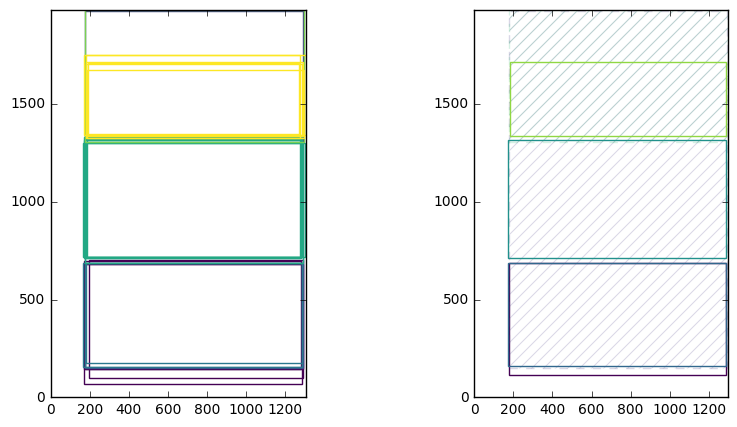

In [15]:
boxFigure = mplplot.figure(figsize=(10,5))
spectralColorMap = matplotlib.cm.get_cmap('viridis')
idx = pd.IndexSlice

allBoxPlot = boxFigure.add_subplot(121, aspect='equal')

allBoxes = allBoxesFrame.ix[idx[1959274], idx[:]][['box', 'bestBoxIndex']]
maxBoxGroup = np.max(allBoxes['bestBoxIndex'].values)
boxColors = [ spectralColorMap(boxGroup/float(maxBoxGroup)) for boxGroup in allBoxes['bestBoxIndex'].values ]

plotBoxes(allBoxes['box'].values, boxColors, axis=allBoxPlot)

meanBoxPlot = boxFigure.add_subplot(122, aspect='equal')

meanBoxes = aggregatedBoxesFrame.ix[idx[1959274], idx[:]][['box']]
maxBoxGroup = len(meanBoxes)
boxColors = [ spectralColorMap(boxGroup/float(maxBoxGroup)) for boxGroup, _ in enumerate(meanBoxes.values) ]
    
plotBoxes(meanBoxes['box'].values, boxColors, axis=meanBoxPlot)

## Write aggregated box data to MySQL database

The following commands create a new table for boxes in the `dcwConsensus` database.

```sql
use dcwConsensus;

CREATE TABLE SubjectBoxes (
id INT AUTO_INCREMENT NOT NULL PRIMARY KEY,
subjectId INT NOT NULL,
bestBoxIndex INT NOT NULL,
collection VARCHAR(50) NOT NULL DEFAULT 'Unspecified',
ledger INT NOT NULL,
page INT NOT NULL,
meanX DECIMAL(7,3) NOT NULL,
meanY DECIMAL(7,3) NOT NULL,
meanWidth DECIMAL(7,3) NOT NULL,
meanHeight DECIMAL(7,3) NOT NULL,
numBoxesMarked INT NOT NULL
);

CREATE TABLE SubjectTelegrams (
id INT AUTO_INCREMENT NOT NULL PRIMARY KEY,
subjectId INT NOT NULL,
collection VARCHAR(50) NOT NULL DEFAULT 'Unspecified',
ledger INT NOT NULL,
page INT NOT NULL,
telegramId INT NOT NULL
);
```

In [16]:
sys.path.append('/Library/Python/2.7/site-packages')
import mysql.connector
#testSubjectData = lineGroupedTranscriptionLineDetails.iloc[0]
connection = mysql.connector.connect(user='root', password='!Ocus1!Ocus1',
                              host='127.0.0.1',
                              database='dcwConsensus')

cursor = connection.cursor()
sentence = ''
try:
    boxInsertQuery = ("INSERT INTO SubjectBoxes (subjectId, bestBoxIndex, collection, ledger, "
                      "page, meanX, meanY, meanWidth, meanHeight, numBoxesMarked) "
                      "SELECT id, %s, %s, %s, %s, %s, %s, %s, %s, %s "
                      "FROM Subjects WHERE huntingtonId = %s")
    
    telegramInsertQuery = ("INSERT INTO SubjectTelegrams (subjectId, collection, ledger, "
                      "page, telegramId) "
                      "SELECT id, %s, %s, %s, %s "
                      "FROM Subjects WHERE huntingtonId = %s")
    
    currentSubject = -1
    subjectId = None
    
    # Loop over aggregated lines in consensus data 
    for index, row in aggregatedBoxesFrame.iterrows() :
        # Insert the aggregated line data
        bestBoxIndex = int(row['bestBoxIndex'])
        boxData = (bestBoxIndex, 
                   row['collection'], 
                   row['ledger'], 
                   row['page'], 
                   row['box'].x,
                   row['box'].y,
                   row['box'].width,
                   row['box'].height,
                   row['box'].data['nBoxes'],
                   row['huntington_id']
                  )
        cursor.execute(boxInsertQuery, boxData)
        
    # Loop over subject frame and insert telegram data
    for index, row in subjectsFrame.iterrows() :
        for telegramNumber in row['telegramNumbers'] :
            telegramData = (row['collection'], 
                            row['ledger'], 
                            row['page'], 
                            telegramNumber, 
                            row['huntington_id'])
            cursor.execute(telegramInsertQuery, telegramData)
            
except mysql.connector.Error as err:
    print("Failed INSERT: {0}, {1}".format(sentence, err))
    
connection.commit()

cursor.close()
connection.close()